## Overlap of Political Organisations and Authors of Academic Research

We look at the overlap between members of various organisations and the authors of the studies in REMP, IM and IMR:

- REMP Board
- ICEM directors and deputy directors
- Dutch Government



In [2]:
import pandas as pd

records_file = '../data/main-review-article-records.csv'

# load the csv data into a data frame
pub_df = pd.read_csv(records_file)
# show the first and last records of the dataset to demonstrate what the records look like
pub_df

,Unnamed: 0,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,issue_number,issue_title,issue_page_range,issue_pub_date,issue_pub_year,volume,journal,publisher,article_type
0,9,The importance of emigration for the solution ...,NaN,"Wander, H.","Wander, H.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,1,Publications of the research group for europea...,Staatsdrukkerij,main
1,11,European emigration overseas past and future,NaN,"Citroen, H.A.","Citroen, H.A.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,2,Publications of the research group for europea...,Staatsdrukkerij,main
2,13,Some aspects of migration problems in the Neth...,NaN,"Beijer, G. && Oudegeest, J.J.","Beijer, G. && Oudegeest, J.J.",&&,NaN,1952,1952,article,NaN,NaN,NaN,1952,1952,3_1,Publications of the research group for europea...,Staatsdrukkerij,main
3,15,Some quantitative aspects of future population...,NaN,"Brink, van den, T.","Brink, van den, T.",NaN,NaN,1952,1952,article,NaN,NaN,NaN,1952,1952,3_2,Publications of the research group for europea...,Staatsdrukkerij,main
4,17,"The refugees as a burden, a stimulus, and a ch...",NaN,"Edding, F.","Edding, F.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,4,Publications of the research group for europea...,Staatsdrukkerij,main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,3907,Chapter Four: Going North,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,63-76,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main
4280,3908,Chapter Five: The New York Labor Market,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,77-109,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main
4281,3909,Chapter Six: The Settlement Process,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,110-119,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main
4282,3910,Chapter Seven: Conclusion,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,120-133,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main


In [3]:
def map_dataset(publisher, article_type):
    # all REMP and IM (published by Wiley) articles are bunlded in a single dataset
    if publisher == 'Staatsdrukkerij' or publisher == 'Wiley':
        return 'REMP_IM'
    # The IMR articles are separated in review articles and research articles
    return 'IMR_research' if article_type == 'main' else 'IMR_review'

pub_df['dataset'] = pub_df.apply(lambda x: map_dataset(x['publisher'], x['article_type']), axis=1)
pub_df.dataset.value_counts()

IMR_review      1842
IMR_research    1539
REMP_IM          903
Name: dataset, dtype: int64

In [4]:
columns = ['article_title', 'issue_pub_year', 'publisher', 'article_type']


In [5]:
pub_df.article_type.value_counts()

main      2399
review    1885
Name: article_type, dtype: int64

In [6]:
pub_df.article_author
temp_df = pub_df[pub_df.article_author.isna() == False]
temp_df[temp_df.article_author.str.contains('Prof')] # Not in article_author_index_name
temp_df[temp_df.article_author.str.contains('HAVEMAN')]
temp_df[temp_df.article_author.str.contains('QUADE')]
temp_df[temp_df.article_author.str.contains('POR')] # POR B.W. HAVEMAN
temp_df[temp_df.article_author.str.contains(' De ')] # Comentario Critico De T. Cnossen

temp_df[temp_df.article_author.str.contains('Father')] # Busa, Father Roberto and Ávila, Father Fernando Bastos
temp_df[temp_df.article_author.str.contains('Comentario')] # Comentario Critico De T. Cnossen -> Cnosses, de T
temp_df[temp_df.article_author.str.contains('Avila')] # Bastos de Avila, F. and Avila, de, F.B.
temp_df[temp_df.article_author.str.contains('\u00c1vila')] # Father Fernando Bastos de Ávila S.J.
temp_df[temp_df.article_author.str.contains('Hof')] # 


,Unnamed: 0,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,issue_number,issue_title,issue_page_range,issue_pub_date,issue_pub_year,volume,journal,publisher,article_type,dataset
7,23,Some remarks on selective migration,NaN,"Hofstee, E.W.","Hofstee, E.W.",NaN,NaN,1952,1952,article,NaN,NaN,NaN,1952,1952,7,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
43,67,Possibilities for inter-European Migration fro...,NaN,"Hofstee, E.W. && Groenman, Sj.","Hofstee, E.W. && Groenman, Sj.",&&,NaN,1953,1953,article,NaN,NaN,NaN,1953,1953,vol.1,REMP-bulletin,Staatsdrukkerij,main,REMP_IM
51,75,Avantages et inconvenients de l'emigration ext...,NaN,"Brink, van den, T && Hofstee, E.W.","Brink, van den, T && Hofstee, E.W.",&&,NaN,1954,1954,article,NaN,NaN,NaN,1954,1954,vol.2,REMP-bulletin,Staatsdrukkerij,main,REMP_IM
63,87,Some preliminary conclusions concerning intern...,NaN,"Hofstee, E.W.","Hofstee, E.W.",NaN,NaN,1954,1954,article,NaN,NaN,NaN,1954,1954,vol.2,REMP-bulletin,Staatsdrukkerij,main,REMP_IM
137,165,Thwarted exodus : post-war overseas migration ...,NaN,"Hofstede, B.P.","Hofstede, B.P.",NaN,NaN,1964,1964,article,NaN,NaN,NaN,1964,1964,9,Studies in Social Life,Staatsdrukkerij,main,REMP_IM
410,401,On Anticipating The Future,https://onlinelibrary.wiley.com/doi/10.1111/j....,D. H. Hofmeije,"Hofmeije, D H",NaN,156-164,01 July 1966,1966,Original Article,3-4,"International Migration: Vol 4, No 3‐4",139-215,July 1966,1966,4,International Migration,Wiley,main,REMP_IM
1648,853,4: A Sociological Approach toward a General Th...,https://journals.sagepub.com/doi/pdf/10.1177/0...,Hans-Joachim Hoffmann-Nowotny,"Hoffmann-Nowotny, Hans-Joachim",NaN,64-83,"Jan 1, 1981",1981,Article,1_suppl,"International Migration Review - Volume 15, Nu...",NaN,"Jan 01, 1981",1981,15,International Migration Review,Sage Publishing,main,IMR_research
2546,1886,Book Review: Berufsvorbereitende und beruflich...,https://journals.sagepub.com/doi/pdf/10.1177/0...,Hans-Joachim Hoffmann-Nowotny,"Hoffmann-Nowotny, Hans-Joachim",Sociological Institute of the University of Zu...,181-181,"Mar 1, 1987",1987,Book Reviews,1,"International Migration Review - Volume 21, Nu...",NaN,"Mar 01, 1987",1987,21,International Migration Review,Sage Publishing,review,IMR_review
4155,3770,Language Shift and Maintenance in Israel,https://journals.sagepub.com/doi/pdf/10.1177/0...,John E. Hofman && Haya Fisherman,"Hofman, John E && Fisherman, Haya","Haifa University College; Haya Fisherman, The ...",204-226,"Jun 1, 1971",1971,Article,2,"International Migration Review - Volume 5, Num...",NaN,"Jun 01, 1971",1971,5,International Migration Review,Sage Publishing,main,IMR_research
4265,3892,12 Switzerland: Remaining Swiss,https://journals.sagepub.com/doi/pdf/10.1177/0...,Hans-joachim Hoffmann-nowotny && Martin Killias,"Hoffmann-nowotny, Hans-joachim && Killias, Martin",University of Zuerich && University of Lausanne,231-245,"Jan 1, 1993",1993,Article,1_suppl,"International Migration Review - Volume 27, Nu...",NaN,"Jan 01, 1993",1993,27,International Migration Review,Sage Publishing,main,IMR_research


In [8]:
temp_df = pub_df[pub_df.article_author_index_name.isna() == False]
temp_df[temp_df.article_author_index_name.str.contains('Cnossen')]
temp_df[temp_df.article_author_index_name.str.contains(' Por ')]


,Unnamed: 0,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,issue_number,issue_title,issue_page_range,issue_pub_date,issue_pub_year,volume,journal,publisher,article_type,dataset
580,637,Participación de los inmigrantes en la vida de...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Por Jerzy Zubrzycki,"Zubrzycki, Por Jerzy",NaN,181-206,01 July 1964,1964,Original Article,3,"International Migration: Vol 2, No 3",179-251,July 1964,1964,2,International Migration,Wiley,main,REMP_IM
884,1144,"Latinoamericanos en Europa, Aspectos Demogràfi...",https://onlinelibrary.wiley.com/doi/10.1111/j....,Por Julio Morales Vergara,"Vergara, Por Julio Morales",NaN,14-32,01 January 1974,1974,Original Article,1-2,"International Migration: Vol 12, No 1‐2",5-104,January 1974,1974,12,International Migration,Wiley,main,REMP_IM


In [10]:
temp_df = pub_df[pub_df.issue_title.isna() == False]

temp_df[temp_df.issue_title.str.contains('International Migration: Vol 2, No 3')]

,Unnamed: 0,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,issue_number,issue_title,issue_page_range,issue_pub_date,issue_pub_year,volume,journal,publisher,article_type,dataset
580,637,Participación de los inmigrantes en la vida de...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Por Jerzy Zubrzycki,"Zubrzycki, Por Jerzy",NaN,181-206,01 July 1964,1964,Original Article,3,"International Migration: Vol 2, No 3",179-251,July 1964,1964,2,International Migration,Wiley,main,REMP_IM
581,638,La actitud de los dirigentes de grupos de inmi...,https://onlinelibrary.wiley.com/doi/10.1111/j....,D. J. Lawless,"Lawless, D J",NaN,207-218,01 July 1964,1964,Original Article,3,"International Migration: Vol 2, No 3",179-251,July 1964,1964,2,International Migration,Wiley,main,REMP_IM
582,640,Thwarted Exodus,https://onlinelibrary.wiley.com/doi/10.1111/j....,Comentario Critico De T. Cnossen,"Cnossen, de T",NaN,224-227,01 July 1964,1964,Original Article,3,"International Migration: Vol 2, No 3",179-251,July 1964,1964,2,International Migration,Wiley,main,REMP_IM
583,641,Tendencias De La Inmigración En El Canadá,https://onlinelibrary.wiley.com/doi/10.1111/j....,POR G. D. McQUADE,"McQUADE, G D",NaN,228-241,01 July 1964,1964,Original Article,3,"International Migration: Vol 2, No 3",179-251,July 1964,1964,2,International Migration,Wiley,main,REMP_IM


## Clustering Author Names

We want to see which authors published in both journals, and how often. This requires a number of transformations:

1. splitting records of multi-author papers into a record per author
2. normalising author names such that variant spellings are mapped to a single version. 

The latter step is always a risky operation, because using only the surface form of a name can results in two persons with similar names being considered as a single person. Given that this dataset narrowly focuses in only authors of articles in the two journals, we assume the chance that two authors have the same surname and initials is low. 


#### Splitting multi-author records

In [11]:
# Code adapted from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe

import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.fillna('').str.split(' && ')))

# calculate lengths of splits
lens = pub_df['article_author'].fillna('').str.split(' && ').map(len)

# create new dataframe, repeating or chaining as appropriate
split_pub_df = pd.DataFrame({
    'journal': np.repeat(pub_df['journal'], lens),
    'issue_pub_year': np.repeat(pub_df['issue_pub_year'], lens),
    'publisher': np.repeat(pub_df['publisher'], lens),
    'dataset': np.repeat(pub_df['dataset'], lens),
    'article_author': chainer(pub_df['article_author']),
    'article_author_index_name': chainer(pub_df['article_author_index_name']),
    'article_author_affiliation': chainer(pub_df['article_author_affiliation'])
})

split_pub_df = split_pub_df.reset_index(drop=True)
split_pub_df

,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation
0,Publications of the research group for europea...,1951,Staatsdrukkerij,REMP_IM,"Wander, H.","Wander, H.",
1,Publications of the research group for europea...,1951,Staatsdrukkerij,REMP_IM,"Citroen, H.A.","Citroen, H.A.",
2,Publications of the research group for europea...,1952,Staatsdrukkerij,REMP_IM,"Beijer, G.","Beijer, G.",
3,Publications of the research group for europea...,1952,Staatsdrukkerij,REMP_IM,"Oudegeest, J.J.","Oudegeest, J.J.",
4,Publications of the research group for europea...,1952,Staatsdrukkerij,REMP_IM,"Brink, van den, T.","Brink, van den, T.",
...,...,...,...,...,...,...,...
4827,International Migration Review,1986,Sage Publishing,IMR_research,,,
4828,International Migration Review,1986,Sage Publishing,IMR_research,,,
4829,International Migration Review,1986,Sage Publishing,IMR_research,,,
4830,International Migration Review,1986,Sage Publishing,IMR_research,,,


In [12]:
split_pub_df[split_pub_df.article_author.str.contains('Avila')]
split_pub_df[split_pub_df.article_author.str.contains('\u00c1vila')]
split_pub_df[split_pub_df.article_author_index_name.str.contains('Charr')]
#split_pub_df[split_pub_df.article_author_index_name.str.contains('Clark')]
#split_pub_df[split_pub_df.article_author_index_name.str.contains('Daley')]


,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation
663,International Migration,1992,Wiley,REMP_IM,Ambassador Héctor Charry-Samper,"Charry-Samper, Ambassador Héctor",


#### Normalising author names

There is a lot of variation in how author names are represented. Sometimes with full first and middle names, sometime with only the first name or only initials, or the first name in full but the middle names as initials.

We start from the author format where the surname is followed by the first and middle names (field `article_author_index_name`). We apply the following normalisation and mapping steps:

1. transform the `article_author_index_name` to title casing (meaning each initial character of a name part is uppercase and the rest is lowercase),
2. remove everything after the first letter that follows the surname,
3. transform all uses of `ij` to `y` as this Dutch and German names containing `ij` are sometimes spelled with `y`, e.g. `Gunther Beijer` vs. `Gunther Beyer`.


In [13]:
import re 
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def acronym(string):
    if string == 'International Migration':
        return 'IM'
    else:
        return 'IMR'


def normalise_name(author_name):
    author_name = unicode_to_ascii(author_name)
    author_name = author_name.title()
    author_name = author_name.replace('Abandan-Unat', 'Abadan-Unat')
    author_name = author_name.replace('Bastos De Avila', 'Avila')
    author_name = author_name.replace('Purcell Jr.', 'Purcell') # Jr. is dropped from the index name
    # Titles like Father
    titles = ['Father ', 'Ambassador ']
    for title in titles:
        if title in author_name:
            author_name = author_name.replace(title, ' ')
    # Prefix in Spanish and French: Por and Par
    if ' Por ' in author_name:
        author_name = author_name.replace(' Por ', ' ')
    if ' Par ' in author_name:
        author_name = author_name.replace(' Par ', ' ')
    author_name = re.sub(r' +',' ', author_name)
    return author_name.strip()


def parse_surname(author_name: str):
    author_name = normalise_name(author_name)
    return ','.join(author_name.split(',')[:-1]).replace('ij', 'y').title()


def parse_surname_initial(author_name: str):
    author_name = normalise_name(author_name)
    if ',' not in author_name:
        return author_name
    surname = ','.join(author_name.split(',')[:-1]).replace('ij', 'y').title()
    initial = author_name.split(', ')[-1][0]
    return f'{surname}, {initial}'

unicode_to_ascii('\u00c1vila')
unicode_to_ascii('Charry-Samper, Ambassador Héctor')
parse_surname_initial('Charry-Samper, Ambassador Héctor')

'Charry-Samper, H'

In [14]:

split_pub_df['article_author_index_name'] = split_pub_df['article_author_index_name'].str.title()
split_pub_df['author_surname_initial'] = split_pub_df.article_author_index_name.apply(parse_surname_initial)
split_pub_df['author_surname'] = split_pub_df.article_author_index_name.apply(parse_surname)
split_pub_df['issue_pub_decade'] = split_pub_df.issue_pub_year.apply(lambda x: int(x/10)*10)

split_pub_df.journal = split_pub_df.journal.apply(acronym)

split_pub_df

,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,author_surname,issue_pub_decade
0,IMR,1951,Staatsdrukkerij,REMP_IM,"Wander, H.","Wander, H.",,"Wander, H",Wander,1950
1,IMR,1951,Staatsdrukkerij,REMP_IM,"Citroen, H.A.","Citroen, H.A.",,"Citroen, H",Citroen,1950
2,IMR,1952,Staatsdrukkerij,REMP_IM,"Beijer, G.","Beijer, G.",,"Beyer, G",Beyer,1950
3,IMR,1952,Staatsdrukkerij,REMP_IM,"Oudegeest, J.J.","Oudegeest, J.J.",,"Oudegeest, J",Oudegeest,1950
4,IMR,1952,Staatsdrukkerij,REMP_IM,"Brink, van den, T.","Brink, Van Den, T.",,"Brink, Van Den, T","Brink, Van Den",1950
...,...,...,...,...,...,...,...,...,...,...
4827,IMR,1986,Sage Publishing,IMR_research,,,,,,1980
4828,IMR,1986,Sage Publishing,IMR_research,,,,,,1980
4829,IMR,1986,Sage Publishing,IMR_research,,,,,,1980
4830,IMR,1986,Sage Publishing,IMR_research,,,,,,1980


In [15]:
split_pub_df[split_pub_df.author_surname_initial.str.contains('Charry')]

,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,author_surname,issue_pub_decade
663,IM,1992,Wiley,REMP_IM,Ambassador Héctor Charry-Samper,"Charry-Samper, Ambassador Héctor",,"Charry-Samper, H",Charry-Samper,1990


In [16]:
# remove articles with no authors
split_pub_df =  split_pub_df[split_pub_df.article_author != '']
split_pub_df

,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,author_surname,issue_pub_decade
0,IMR,1951,Staatsdrukkerij,REMP_IM,"Wander, H.","Wander, H.",,"Wander, H",Wander,1950
1,IMR,1951,Staatsdrukkerij,REMP_IM,"Citroen, H.A.","Citroen, H.A.",,"Citroen, H",Citroen,1950
2,IMR,1952,Staatsdrukkerij,REMP_IM,"Beijer, G.","Beijer, G.",,"Beyer, G",Beyer,1950
3,IMR,1952,Staatsdrukkerij,REMP_IM,"Oudegeest, J.J.","Oudegeest, J.J.",,"Oudegeest, J",Oudegeest,1950
4,IMR,1952,Staatsdrukkerij,REMP_IM,"Brink, van den, T.","Brink, Van Den, T.",,"Brink, Van Den, T","Brink, Van Den",1950
...,...,...,...,...,...,...,...,...,...,...
4817,IMR,1993,Sage Publishing,IMR_research,Silva Meznaric,"Meznaric, Silva",Institute for Migration and Ethnic Studies Uni...,"Meznaric, S",Meznaric,1990
4818,IMR,1993,Sage Publishing,IMR_research,Jadranka Caci-kumpes,"Caci-Kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...,"Caci-Kumpes, J",Caci-Kumpes,1990
4819,IMR,1993,Sage Publishing,IMR_research,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo","Muto, M",Muto,1990
4820,IMR,1993,Sage Publishing,IMR_research,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow","Shevtsova, L",Shevtsova,1990


In [18]:
temp_df = split_pub_df[['author_surname', 'author_surname_initial']].drop_duplicates()
counts = temp_df.author_surname.value_counts()
for row in temp_df[temp_df.author_surname.apply(lambda x: counts[x] > 2)].sort_values('author_surname').iterrows():
    print(row[1]['author_surname'], row[1]['author_surname_initial'])

 Remp
 Ministry Of Labour Japan
 Migrator
 D.K.
 J.Z.
 Unaids And Iom
 G.C.S.
 A.H.R.
Abraham Abraham, S
Abraham Abraham, M
Abraham Abraham, N
Anderson Anderson, B
Anderson Anderson, P
Anderson Anderson, A
Bailey Bailey, A
Bailey Bailey, S
Bailey Bailey, T
Baker Baker, S
Baker Baker, D
Baker Baker, P
Bennett Bennett, N
Bennett Bennett, A
Bennett Bennett, S
Bernard Bernard, J
Bernard Bernard, R
Bernard Bernard, T
Bernard Bernard, W
Brown Brown, D
Brown Brown, L
Brown Brown, M
Chin Chin, R
Chin Chin, K
Chin Chin, C
Ellis Ellis, R
Ellis Ellis, J
Ellis Ellis, M
Evans Evans, M
Evans Evans, J
Evans Evans, G
Fong Fong, H
Fong Fong, E
Fong Fong, T
Fong Fong, P
Garcia Garcia, P
Garcia Garcia, F
Garcia Garcia, M
Garcia Garcia, J
Garcia Garcia, C
Gerber Gerber, D
Gerber Gerber, S
Gerber Gerber, R
Gonzalez Gonzalez, J
Gonzalez Gonzalez, N
Gonzalez Gonzalez, L
Gonzalez Gonzalez, G
Green Green, S
Green Green, V
Green Green, R
Green Green, A
Griffith Griffith, D
Griffith Griffith, E
Griffith Griffith

In [19]:
split_pub_df[split_pub_df.author_surname == 'Mast, Van Der']
split_pub_df[split_pub_df.author_surname == 'Haveman']
split_pub_df[split_pub_df.author_surname == 'Avila']
split_pub_df[split_pub_df.author_surname.str.contains('Wink')]

,journal,issue_pub_year,publisher,dataset,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,author_surname,issue_pub_decade
2631,IMR,1981,Sage Publishing,IMR_research,Elizabeth Winkler,"Winkler, Elizabeth",,"Winkler, E",Winkler,1980


In [20]:
temp_df = split_pub_df[['publisher', 'author_surname_initial']]
g = temp_df.groupby(['publisher', 'author_surname_initial']).size()
au_pub_df = g.unstack('publisher').fillna(0.0)
au_pub_df

publisher,Sage Publishing,Staatsdrukkerij,Wiley
author_surname_initial,,,
A.H.R.,1.0,0.0,0.0
"Abad, R",2.0,0.0,0.0
"Abadan-Unat, N",6.0,0.0,0.0
"Abalos, D",1.0,0.0,0.0
"Abell, N",1.0,0.0,0.0
...,...,...,...
"Zodgekar, A",0.0,0.0,1.0
"Zolberg, A",4.0,0.0,0.0
"Zubrzycki, J",3.0,3.0,6.0


In [21]:
au_pub_df.sort_values(by=['Staatsdrukkerij', 'Sage Publishing', 'Wiley'], ascending=False)

publisher,Sage Publishing,Staatsdrukkerij,Wiley
author_surname_initial,,,
"Beyer, G",3.0,12.0,9.0
"Edding, F",0.0,4.0,0.0
"Hofstee, E",0.0,4.0,0.0
"Zubrzycki, J",3.0,3.0,6.0
"Richardson, A",3.0,3.0,2.0
...,...,...,...
"Zagorski, K",0.0,0.0,1.0
"Zammit, H",0.0,0.0,1.0
"Zanartu, M",0.0,0.0,1.0


In [24]:
pub_df

,Unnamed: 0,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,issue_number,issue_title,issue_page_range,issue_pub_date,issue_pub_year,volume,journal,publisher,article_type,dataset
0,9,The importance of emigration for the solution ...,NaN,"Wander, H.","Wander, H.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,1,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
1,11,European emigration overseas past and future,NaN,"Citroen, H.A.","Citroen, H.A.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,2,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
2,13,Some aspects of migration problems in the Neth...,NaN,"Beijer, G. && Oudegeest, J.J.","Beijer, G. && Oudegeest, J.J.",&&,NaN,1952,1952,article,NaN,NaN,NaN,1952,1952,3_1,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
3,15,Some quantitative aspects of future population...,NaN,"Brink, van den, T.","Brink, van den, T.",NaN,NaN,1952,1952,article,NaN,NaN,NaN,1952,1952,3_2,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
4,17,"The refugees as a burden, a stimulus, and a ch...",NaN,"Edding, F.","Edding, F.",NaN,NaN,1951,1951,article,NaN,NaN,NaN,1951,1951,4,Publications of the research group for europea...,Staatsdrukkerij,main,REMP_IM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,3907,Chapter Four: Going North,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,63-76,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main,IMR_research
4280,3908,Chapter Five: The New York Labor Market,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,77-109,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main,IMR_research
4281,3909,Chapter Six: The Settlement Process,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,110-119,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main,IMR_research
4282,3910,Chapter Seven: Conclusion,https://journals.sagepub.com/doi/pdf/10.1177/0...,NaN,NaN,NaN,120-133,"Jan 1, 1986",1986,Article,1_suppl,"International Migration Review - Volume 20, Nu...",NaN,"Jan 01, 1986",1986,20,International Migration Review,Sage Publishing,main,IMR_research


## Parsing Person Records

In [22]:
from scripts.network_analysis import retrieve_spreadsheet_records

entity_records = retrieve_spreadsheet_records(record_type='entities')
print('Number of records:' , len(entity_records))


Number of records: 74


In [25]:
import json

for record in entity_records:
    print(json.dumps(record, indent=4))
    #print(record['Organisation'], record['Prs_surname'])

{
    "organisation": "REMP",
    "period_start": "1952",
    "last_known_date": "1983",
    "prs_id": "1",
    "prs_surname": "Beijer",
    "prs_infix": "",
    "prs_initials": "G.",
    "prs_function": "demographer, The Hague",
    "prs_category": "academic",
    "is_academic": "yes",
    "is_public_administration": "",
    "prs_country": "NL",
    "prs_role1": "founder",
    "prs_role2": "member_MC",
    "prs_role3": "secretary-editor",
    "remarks": "director-editor (1969)"
}
{
    "organisation": "REMP",
    "period_start": "1952",
    "last_known_date": "1969",
    "prs_id": "2",
    "prs_surname": "Groenman",
    "prs_infix": "",
    "prs_initials": "Sj.",
    "prs_function": "sociologist, Leiden",
    "prs_category": "academic",
    "is_academic": "1947",
    "is_public_administration": "1943-1950",
    "prs_country": "NL",
    "prs_role1": "founder",
    "prs_role2": "member_MC",
    "prs_role3": "vice-chair_BoD",
    "remarks": ""
}
{
    "organisation": "REMP",
    "period_

In [26]:
import pandas as pd

def parse_author_index_name(row):
    if row['prs_infix'] != '':
        return ', '.join([row['prs_surname'], row['prs_infix'], row['prs_initials']])
    else:
        return ', '.join([row['prs_surname'], row['prs_initials']])
    
board_df = pd.DataFrame(entity_records)
board_df['article_author_index_name'] = board_df.apply(parse_author_index_name, axis=1)
board_df['author_surname_initial'] = board_df.article_author_index_name.apply(parse_surname_initial)
board_df

,organisation,period_start,last_known_date,prs_id,prs_surname,prs_infix,prs_initials,prs_function,prs_category,is_academic,is_public_administration,prs_country,prs_role1,prs_role2,prs_role3,remarks,article_author_index_name,author_surname_initial
0,REMP,1952,1983,1,Beijer,,G.,"demographer, The Hague",academic,yes,,NL,founder,member_MC,secretary-editor,director-editor (1969),"Beijer, G.","Beyer, G"
1,REMP,1952,1969,2,Groenman,,Sj.,"sociologist, Leiden",academic,1947,1943-1950,NL,founder,member_MC,vice-chair_BoD,,"Groenman, Sj.","Groenman, S"
2,REMP,1952,1969,3,Zeegers,,G.H.L.,"economist, sociologist, Nijmegen",academic,yes,1941-1950,NL,founder,member_MC,member_BoD,,"Zeegers, G.H.L.","Zeegers, G"
3,REMP,1952,1969,4,Hofstee,,E.W.,"sociologist, Wageningen",academic,yes,"yes, advisor 5 ministeries",NL,founder,member_BoD,,,"Hofstee, E.W.","Hofstee, E"
4,REMP,1952,1969,5,Bouman,,P.J.,"sociologist, Groningen",academic,yes,,NL,member_BoD,,chair_BoD (1954),,"Bouman, P.J.","Bouman, P"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,ICEM,1970,1988,68,Maselli,,G.,deputy director general,,,,IT,,,,,"Maselli, G.","Maselli, G"
70,ICEM,1989,1993,69,Charry-Samper,,H.,deputy director general,,,,CO,,,,,"Charry-Samper, H.","Charry-Samper, H"
71,ICEM,1994,1999,70,Escaler,,N.L. (Narcisa),deputy director general,,,,PH,,,,,"Escaler, N.L. (Narcisa)","Escaler, N"
72,ICEM,1999,2009,71,Ndioro,,N. (Ndiaye),deputy director general,,,,SN,,,,,"Ndioro, N. (Ndiaye)","Ndioro, N"


In [27]:
board_df[board_df.author_surname_initial.str.contains('Purc')]

,organisation,period_start,last_known_date,prs_id,prs_surname,prs_infix,prs_initials,prs_function,prs_category,is_academic,is_public_administration,prs_country,prs_role1,prs_role2,prs_role3,remarks,article_author_index_name,author_surname_initial
61,ICEM,1988,1998,61,Purcell jr.,,James,director general,,,,USA,,,,,"Purcell jr., James","Purcell, J"


In [28]:
temp_df = board_df[['author_surname_initial', 'organisation']]

g = temp_df.groupby(['author_surname_initial', 'organisation']).size()
org_df = g.unstack('organisation').fillna(0.0)
org_df


organisation,Dutch Government,ICEM,REMP
author_surname_initial,,,
"Appleyard, R",0.0,0.0,1.0
"Avila, F",0.0,0.0,1.0
"Baade, F",0.0,0.0,1.0
"Backer, J",0.0,0.0,1.0
"Besterman, W",0.0,1.0,0.0
...,...,...,...
"Vito, F",0.0,0.0,1.0
"Vitorino, A",0.0,1.0,0.0
"Weinberg, A",0.0,0.0,1.0


In [29]:

au_org_df = pd.merge(au_pub_df.reset_index(), org_df.reset_index(), on='author_surname_initial', how='left').fillna(0.0)

au_org_df



,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
0,A.H.R.,1.0,0.0,0.0,0.0,0.0,0.0
1,"Abad, R",2.0,0.0,0.0,0.0,0.0,0.0
2,"Abadan-Unat, N",6.0,0.0,0.0,0.0,0.0,0.0
3,"Abalos, D",1.0,0.0,0.0,0.0,0.0,0.0
4,"Abell, N",1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2493,"Zodgekar, A",0.0,0.0,1.0,0.0,0.0,0.0
2494,"Zolberg, A",4.0,0.0,0.0,0.0,0.0,0.0
2495,"Zubrzycki, J",3.0,3.0,6.0,0.0,0.0,0.0
2496,"Zucchi, J",1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
au_org_df.sort_values(by=['REMP', 'ICEM', 'Dutch Government'], ascending=False)

,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
82,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0
103,"Avila, F",0.0,2.0,1.0,0.0,0.0,1.0
111,"Backer, J",0.0,0.0,1.0,0.0,0.0,1.0
207,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0
250,"Borrie, W",0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
2493,"Zodgekar, A",0.0,0.0,1.0,0.0,0.0,0.0
2494,"Zolberg, A",4.0,0.0,0.0,0.0,0.0,0.0
2495,"Zubrzycki, J",3.0,3.0,6.0,0.0,0.0,0.0
2496,"Zucchi, J",1.0,0.0,0.0,0.0,0.0,0.0


In [47]:

org_au_df = pd.merge(au_pub_df.reset_index(), org_df.reset_index(), on='author_surname_initial', how='right').fillna(0.0)

org_au_df.sort_values(by=['Dutch Government'], ascending=False)



,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
34,"Klompe, M",0.0,0.0,0.0,1.0,0.0,0.0
66,"Verwey-Jonker, H",0.0,1.0,0.0,1.0,0.0,0.0
24,"Haveman, B",0.0,0.0,4.0,1.0,1.0,0.0
26,"Hofstede, B",0.0,1.0,0.0,1.0,0.0,0.0
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
31,"Jacobson, P",0.0,0.0,0.0,0.0,1.0,1.0
32,"Janne, H",0.0,0.0,0.0,0.0,0.0,1.0
33,"Kant, E",0.0,0.0,0.0,0.0,0.0,1.0
35,"Kulischer, E",0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
org_au_df[org_au_df['Sage Publishing'] > 0]


,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0
5,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0
60,"Thomas, B",2.0,0.0,2.0,0.0,0.0,1.0
61,"Thomas, J",1.0,0.0,1.0,0.0,1.0,0.0
62,"Thompson, L",1.0,0.0,0.0,0.0,1.0,0.0


In [49]:
org_au_df[org_au_df['Wiley'] > 0]


,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0
1,"Avila, F",0.0,2.0,1.0,0.0,0.0,1.0
3,"Backer, J",0.0,0.0,1.0,0.0,0.0,1.0
4,"Besterman, W",0.0,0.0,2.0,0.0,1.0,0.0
5,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0
6,"Borrie, W",0.0,1.0,1.0,0.0,0.0,1.0
9,"Carlin, J",0.0,0.0,2.0,0.0,1.0,0.0
10,"Charry-Samper, H",0.0,0.0,1.0,0.0,1.0,0.0
24,"Haveman, B",0.0,0.0,4.0,1.0,1.0,0.0
41,"Maselli, G",0.0,1.0,2.0,0.0,1.0,0.0


In [50]:
org_au_df[org_au_df['Staatsdrukkerij'] > 0]

,author_surname_initial,Sage Publishing,Staatsdrukkerij,Wiley,Dutch Government,ICEM,REMP
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0
1,"Avila, F",0.0,2.0,1.0,0.0,0.0,1.0
5,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0
6,"Borrie, W",0.0,1.0,1.0,0.0,0.0,1.0
8,"Brink, Van Den, T",0.0,2.0,0.0,0.0,0.0,1.0
13,"Edding, F",0.0,4.0,0.0,0.0,0.0,1.0
17,"Gadolin, De, A",0.0,2.0,0.0,0.0,0.0,1.0
20,"Gottmann, J",0.0,1.0,0.0,0.0,0.0,1.0
22,"Groenman, S",0.0,2.0,0.0,0.0,0.0,1.0
26,"Hofstede, B",0.0,1.0,0.0,1.0,0.0,0.0


In [51]:
org_au_df.to_csv('../data/authors-organisations-overlap.csv')

In [52]:
au_org_df.to_csv('../data/authors-organisations-overlap-all.csv')

### My Section

In [99]:
overlap_df = org_au_df

overlap_df.rename(columns={'Sage Publishing':'IMR-Sage', 'Staatsdrukkerij':'REMP-Staatsdrukkerij', 'Wiley':'IM-Wiley',
       'Dutch Government':'Dutch_Government'}, inplace=True)
overlap_df.columns

article_cols = ['IMR-Sage', 'REMP-Staatsdrukkerij','IM-Wiley']
governance_cols = ['Dutch_Government', 'ICEM', 'REMP']

In [58]:
overlap_df['total'] = overlap_df[['IMR-Sage', 'REMP-Staatsdrukkerij', 'IM-Wiley',
       'Dutch_Government', 'ICEM', 'REMP']].sum(axis=1)

In [59]:
overlap_df.sort_values(['total'], ascending=False)

,author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total
5,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0,25.0
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0,23.0
24,"Haveman, B",0.0,0.0,4.0,1.0,1.0,0.0,6.0
60,"Thomas, B",2.0,0.0,2.0,0.0,0.0,1.0,5.0
27,"Hofstee, E",0.0,4.0,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
42,"Mckinley, B",0.0,0.0,0.0,0.0,1.0,0.0,1.0
43,"Mertens De Wilmars, J",0.0,0.0,0.0,0.0,0.0,1.0,1.0
18,"Gelissen, H",0.0,0.0,0.0,0.0,0.0,1.0,1.0
45,"Neundorffer, L",0.0,0.0,0.0,0.0,0.0,1.0,1.0


and then the count

In [60]:
def countcols(x):
    return len([c for c in x[2:8] if c>0])

In [61]:
from statistics import mean
def meancols(x):
    return mean([c for c in x[2:8]])

In [62]:
overlap_df["network_count"] = overlap_df.apply(lambda x: countcols(x), axis=1)

In [63]:
overlap_df["network_mean"] = overlap_df.apply(lambda x: meancols(x), axis=1)

In [64]:
overlap_df.sort_values(['network_count','network_mean','total'], ascending=False)

,author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean
5,"Beyer, G",3.0,12.0,9.0,0.0,0.0,1.0,25.0,4,7.833333
0,"Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0,23.0,4,7.500000
24,"Haveman, B",0.0,0.0,4.0,1.0,1.0,0.0,6.0,4,2.000000
1,"Avila, F",0.0,2.0,1.0,0.0,0.0,1.0,4.0,4,1.333333
41,"Maselli, G",0.0,1.0,2.0,0.0,1.0,0.0,4.0,4,1.333333
...,...,...,...,...,...,...,...,...,...,...
64,"Vampa, D",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333
65,"Vergottini, M",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333
67,"Vito, F",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333
68,"Vitorino, A",0.0,0.0,0.0,0.0,1.0,0.0,1.0,2,0.333333


In [65]:
counted_values = overlap_df.network_count.value_counts()
vals = list(counted_values.index)
vals.sort(reverse=True)

In [98]:
counted_values

2    41
3    23
4     8
Name: network_count, dtype: int64

In [67]:
vals

[4, 3, 2]

In [68]:
mean_values = overlap_df.network_mean.value_counts()
means = list(mean_values.index)
means.sort(reverse=True)


In [69]:
mean_values

0.333333    40
1.000000    11
0.666667    10
1.333333     4
1.666667     2
0.833333     1
7.833333     1
0.500000     1
2.000000     1
7.500000     1
Name: network_mean, dtype: int64

In [70]:
means

[7.833333333333333,
 7.5,
 2.0,
 1.6666666666666667,
 1.3333333333333333,
 1.0,
 0.8333333333333334,
 0.6666666666666666,
 0.5,
 0.3333333333333333]

In [123]:
board_df[['author_surname_initial', 'prs_category']]

,author_surname_initial,prs_category
0,"Beyer, G",academic
1,"Groenman, S",academic
2,"Zeegers, G",academic
3,"Hofstee, E",academic
4,"Bouman, P",academic
...,...,...
69,"Maselli, G",
70,"Charry-Samper, H",
71,"Escaler, N",
72,"Ndioro, N",


In [125]:
pd.merge(left=overlap_df, right=board_df[['author_surname_initial', 'prs_category']],
         left_on=overlap_df.author_surname_initial, right_on='author_surname_initial', how='left')

,author_surname_initial,author_surname_initial_x,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean,author_surname_initial_y,prs_category
0,"Appleyard, R","Appleyard, R",1.0,2.0,19.0,0.0,0.0,1.0,23.0,4,7.500000,"Appleyard, R",academic
1,"Avila, F","Avila, F",0.0,2.0,1.0,0.0,0.0,1.0,4.0,4,1.333333,"Avila, F",academic
2,"Baade, F","Baade, F",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333,"Baade, F",academic
3,"Backer, J","Backer, J",0.0,0.0,1.0,0.0,0.0,1.0,2.0,3,0.666667,"Backer, J",academic
4,"Besterman, W","Besterman, W",0.0,0.0,2.0,0.0,1.0,0.0,3.0,3,1.000000,"Besterman, W",
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"Vito, F","Vito, F",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333,"Vito, F",academic
70,"Vitorino, A","Vitorino, A",0.0,0.0,0.0,0.0,1.0,0.0,1.0,2,0.333333,"Vitorino, A",
71,"Weinberg, A","Weinberg, A",0.0,2.0,1.0,0.0,0.0,1.0,4.0,4,1.333333,"Weinberg, A",academic
72,"Winkler, W","Winkler, W",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,0.333333,"Winkler, W",academic


In [109]:
from IPython.core.display import display, HTML
style = "style='display:inline'"


for i in vals:
    if i>1: # we only want those who appear frequently
        res = overlap_df.loc[overlap_df.network_count==i]
        #res = res[numcols].apply(lambda x: x.round(0))
        display(res.style
                .set_table_attributes(style)
                .set_caption(f'<h1>{i} networks<h1>')
                .set_precision(0)
               .apply(lambda x:highlight_max(x, color='orange'), subset=article_cols, axis=0)
               .apply(lambda x:highlight_max(x, color='red'), subset=governance_cols, axis=0))

,author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean
0,"Appleyard, R",1,2,19,0,0,1,23,4,8
1,"Avila, F",0,2,1,0,0,1,4,4,1
5,"Beyer, G",3,12,9,0,0,1,25,4,8
6,"Borrie, W",0,1,1,0,0,1,3,4,1
24,"Haveman, B",0,0,4,1,1,0,6,4,2
41,"Maselli, G",0,1,2,0,1,0,4,4,1
57,"Sauvy, A",0,1,1,0,0,1,3,4,1
69,"Weinberg, A",0,2,1,0,0,1,4,4,1


,author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean
3,"Backer, J",0,0,1,0,0,1,2,3,1
4,"Besterman, W",0,0,2,0,1,0,3,3,1
8,"Brink, Van Den, T",0,2,0,0,0,1,3,3,1
9,"Carlin, J",0,0,2,0,1,0,3,3,1
10,"Charry-Samper, H",0,0,1,0,1,0,2,3,1
13,"Edding, F",0,4,0,0,0,1,5,3,2
17,"Gadolin, De, A",0,2,0,0,0,1,3,3,1
20,"Gottmann, J",0,1,0,0,0,1,2,3,1
22,"Groenman, S",0,2,0,0,0,1,3,3,1
26,"Hofstede, B",0,1,0,1,0,0,2,3,1


,author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean
2,"Baade, F",0,0,0,0,0,1,1,2,0
7,"Bouman, P",0,0,0,0,0,1,1,2,0
11,"Clark, C",0,0,0,0,0,1,1,2,0
12,"Daley, M",0,0,0,0,1,0,1,2,0
14,"Epinat, B",0,0,0,0,1,0,1,2,0
15,"Escaler, N",0,0,0,0,1,0,1,2,0
16,"Fougstedt, G",0,0,0,0,0,1,1,2,0
18,"Gelissen, H",0,0,0,0,0,1,1,2,0
19,"Gibson, H",0,0,0,0,1,0,1,2,0
21,"Goudswaard, G",0,0,0,0,0,1,1,2,0


In [121]:
from IPython.core.display import display, HTML
style = "style='display:inline'"



res = overlap_df.loc[overlap_df.network_count>1]
res = res.sort_values(['network_count', 'network_mean', 'total'], ascending=False)
#res = res[numcols].apply(lambda x: x.round(0))
display(res.style
        .set_table_attributes(style)
        .set_caption(f'<h1>network overlap<h1>')
        .set_precision(0)
        .hide_index()
        .apply(lambda x:highlight_max(x, color='orange'), subset=article_cols, axis=0)
        .apply(lambda x:highlight_max(x, color='red'), subset=governance_cols, axis=0))

author_surname_initial,IMR-Sage,REMP-Staatsdrukkerij,IM-Wiley,Dutch_Government,ICEM,REMP,total,network_count,network_mean
"Beyer, G",3,12,9,0,0,1,25,4,8
"Appleyard, R",1,2,19,0,0,1,23,4,8
"Haveman, B",0,0,4,1,1,0,6,4,2
"Avila, F",0,2,1,0,0,1,4,4,1
"Maselli, G",0,1,2,0,1,0,4,4,1
"Weinberg, A",0,2,1,0,0,1,4,4,1
"Borrie, W",0,1,1,0,0,1,3,4,1
"Sauvy, A",0,1,1,0,0,1,3,4,1
"Edding, F",0,4,0,0,0,1,5,3,2
"Hofstee, E",0,4,0,0,0,1,5,3,2


In [108]:
# all this is stolen from https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
df = pd.DataFrame([[2,3,-3], [3,2,7], [2,4,4]], columns=list("ABC"))
def highlight_cel(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val > 1:
        color = 'red'
    else:
        color = ''
    return 'background-color: %s' % color

import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = df.style.background_gradient(cmap=cm, subset=['C'])
s

def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if data.max() > 0:
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        if data.max().max() > 0:
            is_max = data == data.max().max()
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)


def highlight_person(data, column, condition, color='red'):
    # works on rows (axis=1)
    attr = 'background-color: {}'.format(color)
    if data[column] == condition:
        return attr
        
#df.style.applymap(lambda x: color_negative_red(x))
# df.style.apply(lambda x: ["background-color: #ff33aa" 
#                           if (i >= 2 and (v > x.iloc[0] + x.iloc[1] 
#                                           or v < x.iloc[0] - x.iloc[1])) 
#                           else "" for i, v in enumerate(x)], axis = 1)

In [ ]:
oefendf = overlap_df
oefendf.style.apply(lambda x: ["background-color: #ff33aa" 
                          if (i >= 2 and (v > x.iloc[0] + x.iloc[1] 
                                          or v < x.iloc[0] - x.iloc[1])) 
                          else "" for i, v in enumerate(x)], axis = 1)

## Old Analysis, Needs Redoing

### Looking at author overlap between journal

There following 212 authors who have published in both journals:

In [274]:
g = df_split[df_split.author_surname_initial.isna() == False].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
df_overlap[(df_overlap.IM > 0) & (df_overlap.IMR > 0)]


journal,IM,IMR
author_surname_initial,,
"Adepoju, A",11.0,1.0
"Afolayan, A",1.0,1.0
"Agadjanian, V",2.0,2.0
"Al-Qudsi, S",1.0,1.0
"Allen, R",1.0,1.0
...,...,...
"Young, C",1.0,1.0
"Zhou, M",1.0,5.0
"Zlotnik, H",2.0,7.0


There are 54 authors who published at least two articles in each journal. Here we see Gunther Beijer and and Jerzy Zubrzicki, who are also directly involved in the REMP publications:

In [275]:
g = df_split[df_split.author_surname_initial.isna() == False].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
print('number of authors with at least two articles in both journals:', 
      len(df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 1)]))

df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 1)]

number of authors with at least two articles in both journals: 54


journal,IM,IMR
author_surname_initial,,
"Agadjanian, V",2.0,2.0
"Appleyard, R",25.0,3.0
"Basok, T",2.0,5.0
"Beenstock, M",3.0,2.0
"Bernard, W",6.0,7.0
"Beyer, G",16.0,3.0
"Brandon, P",2.0,2.0
"Burnley, I",2.0,3.0
"Böhning, W",4.0,7.0


In [236]:
print('Number of authors in both journals combined:', len(df_overlap))
print('Number of authors in International Migration:', len(df_overlap[df_overlap.IM > 0]))
print('Number of authors in International Migration Review:', len(df_overlap[df_overlap.IMR > 0]))


Number of authors in both journals combined: 3682
Number of authors in International Migration: 1201
Number of authors in International Migration Review: 2693


The 212 authors with articles in both journals represent 18% of all IM authors ($212 / 1201 = 0.18$) and 8% ($212 / 2693 = 0.08$) of all IMR authors. 

In [241]:
print(round(212/1201, 2))
print(round(212/2693, 2))

0.18
0.08


In [245]:
print('Number of persons who published multiple articles in IM:', len(df_overlap[df_overlap.IM > 1]))

print('Number of multi-IM authors who also published in IMR:', len(df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 0)]))

Number of persons who published multiple articles in IM: 227
Number of multi-IM authors who also published in IMR: 91


In [246]:
print('Number of persons who published multiple articles in IMR:', len(df_overlap[df_overlap.IMR > 1]))

print('Number of multi-IMR authors who also published in IM:', len(df_overlap[(df_overlap.IMR > 1) & (df_overlap.IM > 0)]))

Number of persons who published multiple articles in IMR: 769
Number of multi-IMR authors who also published in IM: 109


In [252]:
print('IM:', len(df_overlap[df_overlap.IM > 1]) / len(df_overlap[df_overlap.IM > 0]))
print('IMR:', len(df_overlap[df_overlap.IMR > 1]) / len(df_overlap[df_overlap.IMR > 0]))

print('IM:', len(df_overlap[df_overlap.IM > 4]) / len(df_overlap[df_overlap.IM > 0]))
print('IMR:', len(df_overlap[df_overlap.IMR > 4]) / len(df_overlap[df_overlap.IMR > 0]))



IM: 0.18900915903413823
IMR: 0.28555514296323803
IM: 0.019150707743547043
IMR: 0.05124396583735611


In [262]:
print(df_overlap[df_overlap.IMR > 1].shape)
df_overlap[df_overlap.IMR > 1].IM.value_counts()

(769, 2)


0.0     660
1.0      55
2.0      21
4.0      11
3.0       9
5.0       3
8.0       2
11.0      2
6.0       2
7.0       1
14.0      1
16.0      1
25.0      1
Name: IM, dtype: int64

In [264]:
print(df_overlap[df_overlap.IM > 1].shape)
df_overlap[df_overlap.IM > 1].IMR.value_counts()

(227, 2)


0.0     136
1.0      37
2.0      21
3.0      10
7.0       6
4.0       4
5.0       4
8.0       2
9.0       2
6.0       1
13.0      1
27.0      1
40.0      1
14.0      1
Name: IMR, dtype: int64

In [263]:
305/371
660/769

0.8582574772431729

<AxesSubplot:xlabel='IM', ylabel='IMR'>

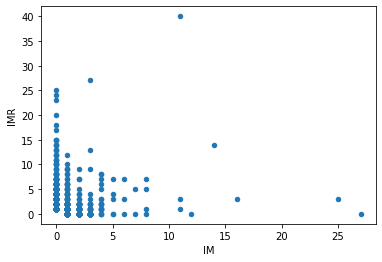

In [279]:
df_overlap.plot(kind='scatter', x='IM', y='IMR')

In [278]:
g = df_split[(df_split.author_surname_initial.isna() == False) & (df_split.author_surname_initial != '')].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
df_overlap

journal,IM,IMR
author_surname_initial,,
"Abadan-Unat, N",0.0,6.0
"Abaka, E",0.0,1.0
"Abalos, D",0.0,1.0
"Abandan-Unat, N",0.0,1.0
"Abascal, M",0.0,1.0
...,...,...
"Ávila, F",1.0,0.0
"Åkesson, L",1.0,0.0
"Åslund, O",0.0,1.0


In [277]:
df_split[df_split.author_surname_initial.isna() == False]

,journal,issue_pub_year,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,issue_pub_decade
0,IM,2010,Douglas S. Massey,"Massey, Douglas S",,"Massey, D",2010
1,IM,2010,Nathalie Williams,"Williams, Nathalie",,"Williams, N",2010
2,IM,2010,William G. Axinn,"Axinn, William G",,"Axinn, W",2010
3,IM,2010,Dirgha J. Ghimire,"Ghimire, Dirgha J",,"Ghimire, D",2010
4,IM,2010,Aderanti Adepoju,"Adepoju, Aderanti",,"Adepoju, A",2010
...,...,...,...,...,...,...,...
6769,IMR,1993,Nermin Abadan-unat,"Abadan-Unat, Nermin",University of Ankara,"Abadan-Unat, N",1990
6770,IMR,1993,Silva Meznaric & Jadranka Caci-kumpes,"Meznaric, Silva & Caci-Kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...,"Meznaric, S",1990
6771,IMR,1993,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo","Muto, M",1990
6772,IMR,1993,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow","Shevtsova, L",1990
